In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator
from statsmodels.tsa.arima_model import ARMA

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [4]:
def readFile(filename):
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.",filename)
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [8]:
DC_HPI = readFile("DC_HousePriceIndex.csv")

File read into dataframe. DC_HousePriceIndex.csv
(39, 1)


In [38]:
DC_HPI.dtypes

DC_HousePriceIndex    float64
dtype: object

In [9]:
DC_HPI.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [10]:
DC_HPI.head()

,DC_HousePriceIndex
1977-01-01,65.7325
1978-01-01,77.0050
1979-01-01,90.7075
1980-01-01,98.6525
1981-01-01,99.6425


In [11]:
DC_HPI.DC_HousePriceIndex.describe()

count     39.000000
mean     300.456410
std      211.514685
min       65.732500
25%      129.137500
50%      192.920000
75%      549.686250
max      740.742500
Name: DC_HousePriceIndex, dtype: float64

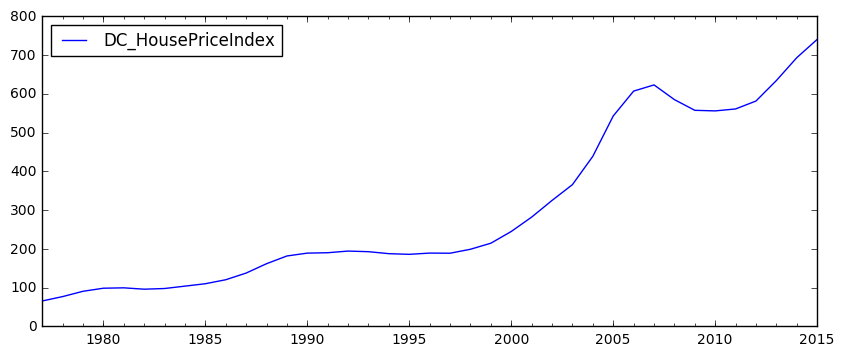

In [12]:
DC_HPI.plot(figsize=(10,4))
plt.show()

There is an overall increasing trend in the data with some cyclic variation in 2007, we can see dip which is obvious as in case of crisis.


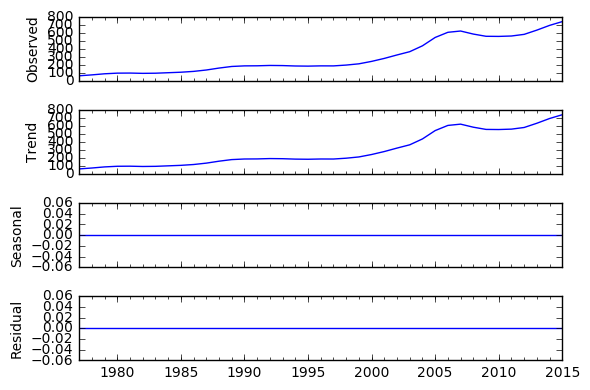

In [13]:
#Decomposing into  trend, seasonal and residual using additive model.
decomposition = sm.tsa.seasonal_decompose(DC_HPI, model='additive')
fig = decomposition.plot()
plt.show()
#fig.savefig('Seasonal_Decompose.png', dpi=150)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not. First, check the mean and variance. Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [12]:
#we can split our dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [13]:
meanVarianceCheck(DC_HPI)

('mean1=135.936842, mean2=456.750000',
 'variance1=2029.383366, variance2=32934.123121')

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

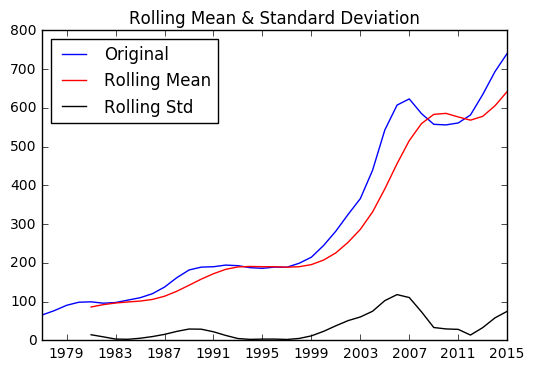

Results of Dickey-Fuller Test:
Test Statistic                  0.871213
p-value                         0.992703
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64


In [15]:
test_stationarity(DC_HPI.DC_HousePriceIndex)

# Estimating & Eliminating Trend

In [19]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

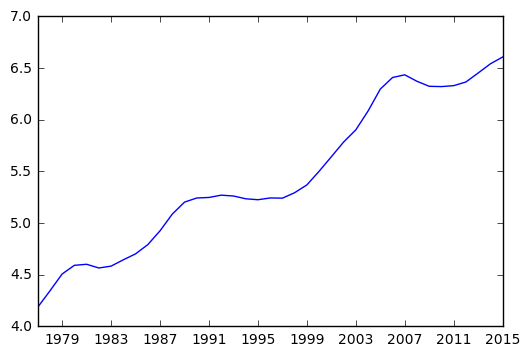

In [20]:
ts_log = logTransform(DC_HPI)

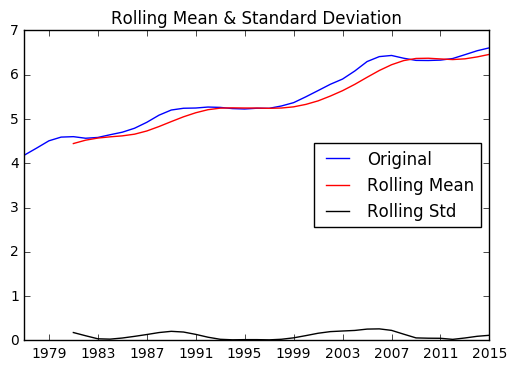

Results of Dickey-Fuller Test:
Test Statistic                 -0.201415
p-value                         0.938353
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64


In [18]:
test_stationarity(ts_log.DC_HousePriceIndex)

Though the variation in standard deviation is small, mean is increasing with time. Test Statistics is 

In [75]:
#Differencing - taking the differece with a particular time lag
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

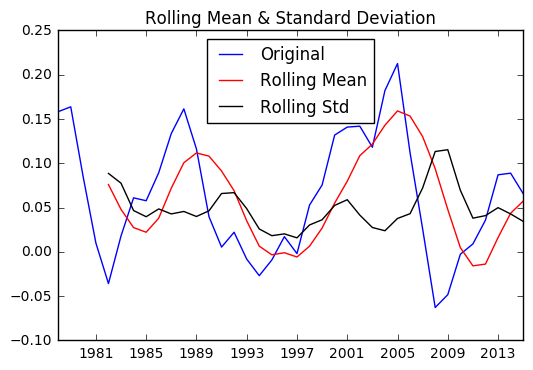

Results of Dickey-Fuller Test:
Test Statistic                 -4.127889
p-value                         0.000871
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64


In [77]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.DC_HousePriceIndex)

In [21]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

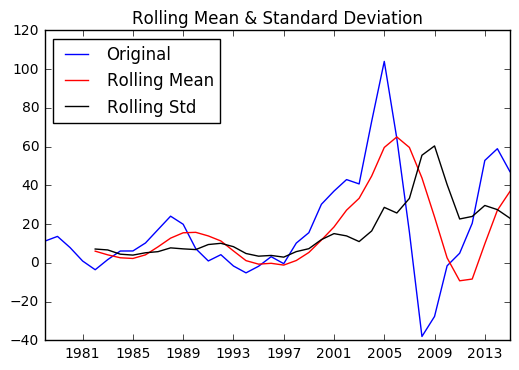

Results of Dickey-Fuller Test:
Test Statistic                 -4.024085
p-value                         0.001290
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64


In [22]:
ts_first_diff = firstDifference(DC_HPI)
test_stationarity(ts_first_diff.DC_HousePriceIndex)

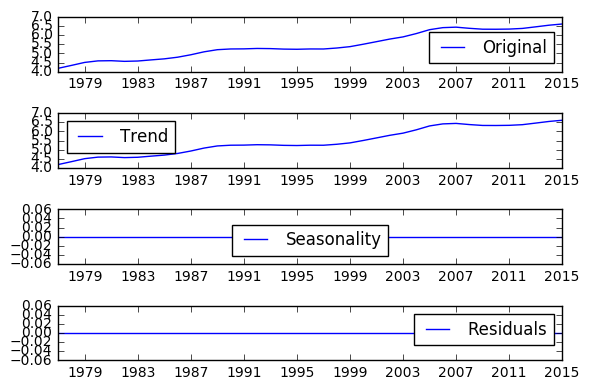

In [157]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

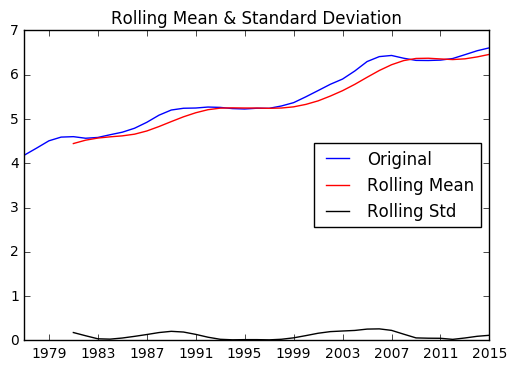

Results of Dickey-Fuller Test:
Test Statistic                 -0.201415
p-value                         0.938353
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
Critical Value (1%)            -3.626652
dtype: float64


In [158]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.DC_HousePriceIndex)

In [25]:
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

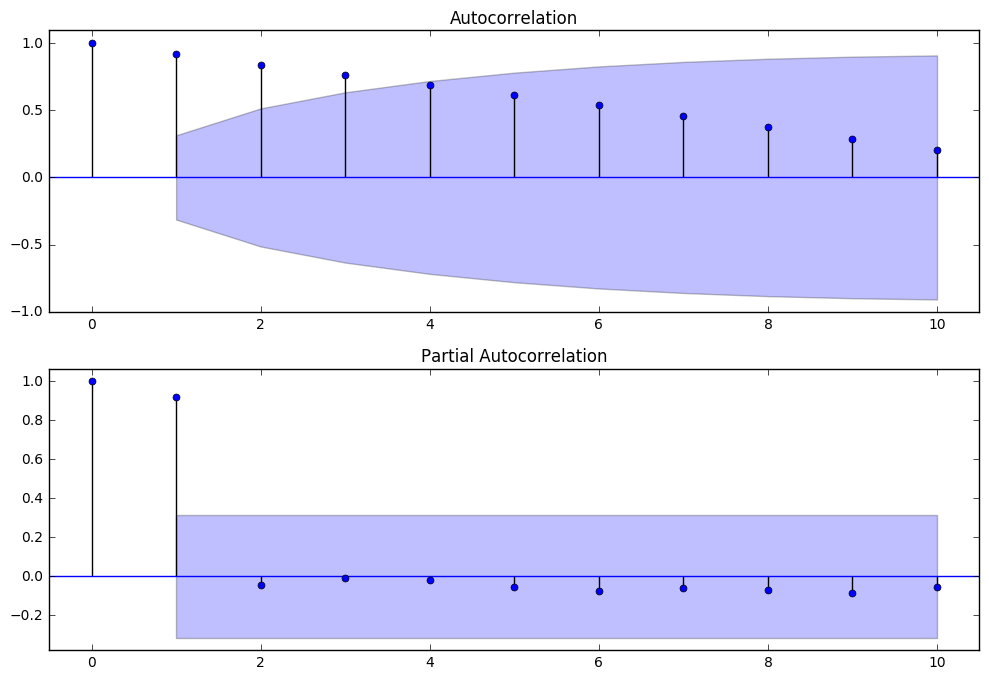

In [282]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log, lags=10, ax=ax2)

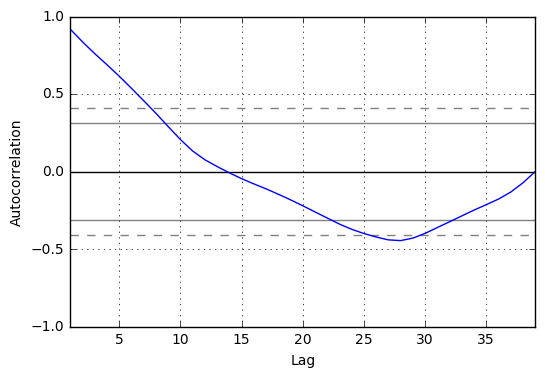

In [168]:
autocorrelation_plot(ts_log)
plt.show()

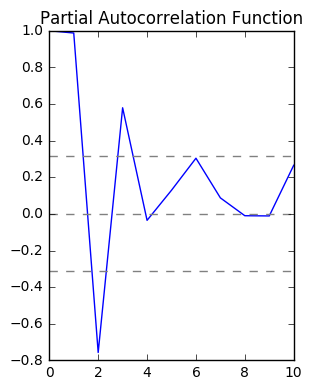

In [169]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [15]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [16]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

# ARIMA Models

In [23]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    #print(results_AR.summary())
    predict_MA_HPI = np.exp(results_AR.predict(10, 15, dynamic=True))
    print(predict_MA_HPI)
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    #print(np.exp(results_AR.fittedvalues))
    print(results_AR.aic)
    return results_AR

Lag: 2
Coefficients: const                       5.233453
ar.L1.DC_HousePriceIndex    1.882465
ar.L2.DC_HousePriceIndex   -0.887953
dtype: float64
1987-01-01    130.791685
1988-01-01    140.919405
1989-01-01    150.803736
1990-01-01    160.351462
1991-01-01    169.480018
1992-01-01    178.118856
Freq: AS-JAN, dtype: float64
-115.28772577460953


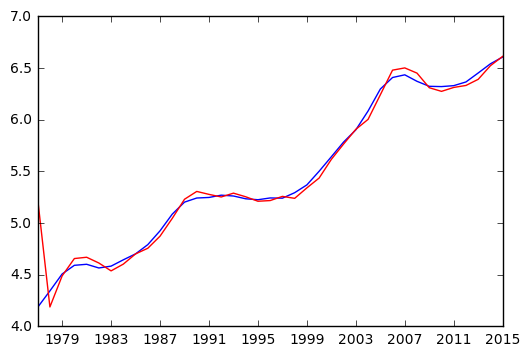

In [24]:
model_AR = AR_Model(ts_log)

In [25]:
def MA_Model(ts):
    model = ARIMA(ts, order=(0, 0, 7))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 7))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                       5.445215
ma.L1.DC_HousePriceIndex    3.316988
ma.L2.DC_HousePriceIndex    6.449835
ma.L3.DC_HousePriceIndex    8.756583
ma.L4.DC_HousePriceIndex    8.756581
ma.L5.DC_HousePriceIndex    6.449830
ma.L6.DC_HousePriceIndex    3.316984
ma.L7.DC_HousePriceIndex    0.999998
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     DC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(0, 7)   Log Likelihood                  51.020
Method:                       css-mle   S.D. of innovations              0.048
Date:                Thu, 27 Apr 2017   AIC                            -84.040
Time:                        16:34:42   BIC                            -69.068
Sample:                    01-01-1977   HQIC                           -78.669
                         - 01-01-2015                                         
                               coef 

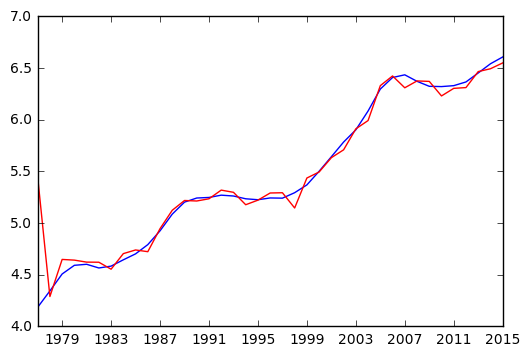

In [26]:
model_MA = MA_Model(ts_log)

In [31]:
def Combined_Model(ts):
    model = ARIMA(ts, order=(2, 0, 4))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2,0, 4))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 2
Coefficients: const                       5.329545
ar.L1.DC_HousePriceIndex    1.692701
ar.L2.DC_HousePriceIndex   -0.699663
ma.L1.DC_HousePriceIndex    0.735143
ma.L2.DC_HousePriceIndex    0.311418
ma.L3.DC_HousePriceIndex   -0.021426
ma.L4.DC_HousePriceIndex   -0.019376
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     DC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 4)   Log Likelihood                  68.220
Method:                       css-mle   S.D. of innovations              0.037
Date:                Thu, 27 Apr 2017   AIC                           -120.440
Time:                        16:35:16   BIC                           -107.132
Sample:                    01-01-1977   HQIC                          -115.665
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|     

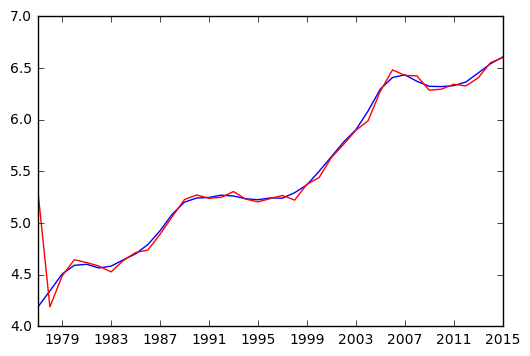

In [32]:
model_Combined = Combined_Model(ts_log)

In [33]:
aic_metric

,AIC,Modelname
0,-115.287726,"ARIMA(ts, order=(2, 0, 0))"
0,-115.287726,"ARIMA(ts, order=(2, 0, 0))"
0,-84.040433,"ARIMA(ts, order=(0, 0, 7))"
0,-120.440428,"ARIMA(ts, order=(2,0, 4))"


In [34]:
aic_dict

{'ARIMA(ts, order=(0, 0, 7))': -84.04043304395725,
 'ARIMA(ts, order=(2, 0, 0))': -115.28772577460953,
 'ARIMA(ts, order=(2,0, 4))': -120.44042754535744}

In [35]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2,0, 4))


In [36]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output    

In [37]:
output_forecast = forecast(model_AR,5)

[ 779.37677304  809.0160035   829.5929283   841.40564979  845.04288752]


In [ ]:

#AR model
#model = ARIMA(ts_log, order=(4, 1, 0))
#results_AR = model.fit(disp=0)  
#print(results_AR.summary())
##print('Lag: %s' % results_AR.k_ar)
#print('Coefficients: %s' % results_AR.params)
#plt.plot(ts_log_diff)
#plt.plot(results_AR.fittedvalues, color='red')
#print(results_AR.aic)

#MA model
#model = ARIMA(ts_log, order=(0, 1, 1))  
#results_MA = model.fit(disp=-1)  
#print('Lag: %s' % results_MA.k_ar)
#print('Coefficients: %s' % results_MA.params)
#print(results_MA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_MA.fittedvalues, color='red')


#Combined model
#model = ARIMA(ts_log, order=(2, 1, 2))  
#results_ARIMA = model.fit(disp=-1) 
#print('Lag: %s' % results_ARIMA.k_ar)
#print('Coefficients: %s' % results_ARIMA.params)
#print(results_ARIMA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')